# Notebook 3: Posture Layer

### General Overview

The posture layer consists of two sub-layers: one tasked with climbing classification (climbing classifier neuron (CCN)) and another responsible for providing a body pitch time course (two pitch estimator neurons (PENs)). These layers were designed to test whether higher-order whole-body locomotion parameters could be extracted from low-level phasic-tonic proprioceptor information. An appropriate higher order posture parameter to extract was body pitch, since the experimental setup required transient, large-amplitude adjustments of the stick insects' body pitch due to the physical steps the insect encountered. Therefore, body pitch was chosen as the locomotion parameter to predict, instead of roll or yaw.

### Cell-by-Cell Description

#### Importing Modules and Creating Folders

This cell serves to import general functions, modules, and dictionaries from the 'general' module. Additionally, it imports the LIF class, which is integral to subsequent analyses. The LIF class is a simplified LIF neuron, see 'classes.py' for more information.


In [2]:
from general import *
from classes import LIF

create_folder_if_not_exists('images')
create_folder_if_not_exists('images/posture_neuron')

Folder 'images' already exists.
Folder 'images/posture_neuron' already exists.


In [3]:
# Load joint angles, movement primitive and pitch data from files, all for trials with steps
with open('temp_data/joint_angles_step', 'rb') as file:
    joint_angles = np.load(file)
    
with open('temp_data/spike_primitive_step', 'rb') as file:
    spike_primitive = np.load(file)
    
with open('temp_data/pitch_step', 'rb') as file:
    pitch = np.load(file)

# Remove some simulations that do not include two steps
remove = [4, 6, 10, 11, 12, 18]

joint_angles = np.delete(joint_angles, remove, axis=2)
spike_primitive = np.delete(spike_primitive, remove, axis=2)
pitch = np.delete(pitch, remove, axis=1)

We want to plot body pitch for one of the trials to show the two climbing steps.

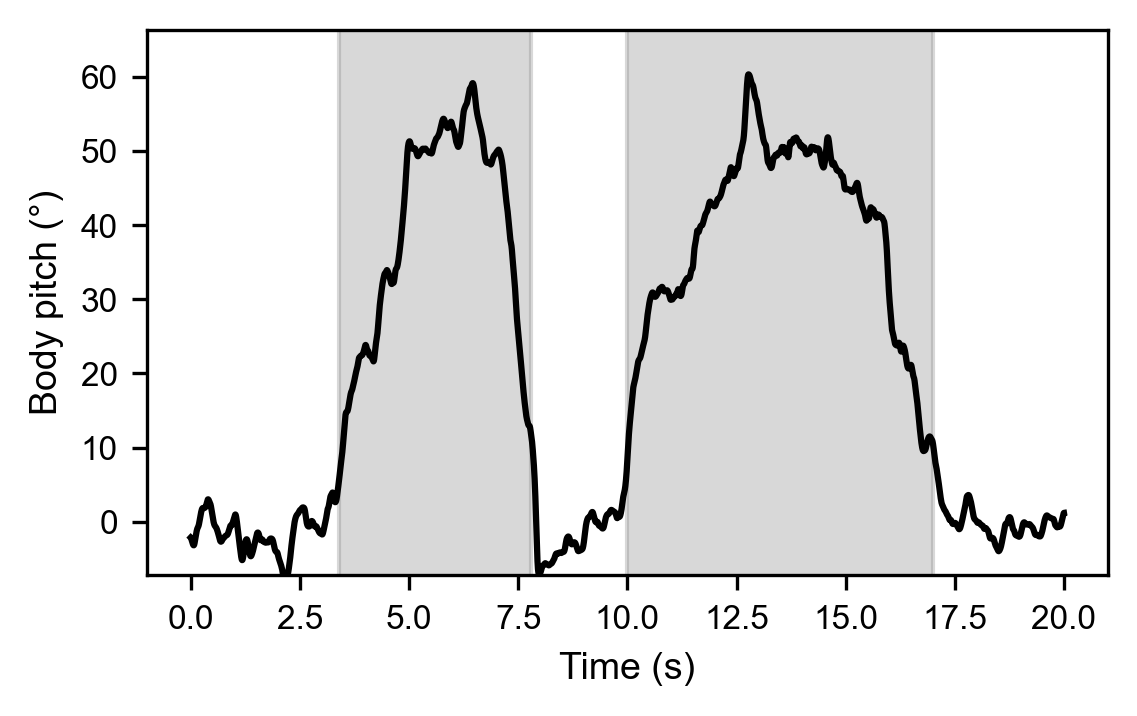

In [4]:
# Index for the trial we want to show
i_pitch = 1

# Generate time array for plotting
time = np.linspace(0, constants['T_TOTAL_STEP'], num=constants['N_STEPS_STEP'])

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot the body pitch over time
plt.plot(time, pitch[:, i_pitch], color='black')

# Set labels and limits
ax.set_xlabel("Time (s)")
ax.set_ylabel("Body pitch (°)")
ax.set_ylim([0.9 * np.min(pitch[:, i_pitch]), 1.1 * np.max(pitch[:, i_pitch])])

# Highlight climbing intervals with grey shading
ax.fill_between([3.4, 7.8], -100, 200, alpha=0.3, color='grey')
ax.fill_between([10, 17], -100, 200, alpha=0.3, color='grey')

# Save the figure
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/posture_neuron/P2_fig1c.png')

### Climbing Classifier Neuron

This cell defines the simulation parameters, grid search parameters, and Climbing Classifier Neuron (CCN) parameters. Additionally, an array named `pitch_binary` is created, which is set to 1 if the stick insect is climbing (defined as body pitch > 10°) and 0 otherwise.

In [5]:
# Define constants and parameters
N_PRIM_NEURONS = 672
N_SIMULATIONS_TEST = 1
N_SIMULATIONS_STEP = 15
N_BINS = 50

# Define grid search parameters
w_array_ccn = np.linspace(5E-5, 2E-4, num=10)  # 10 weights
ratio_array_ccn = np.linspace(1.6, 2, num=5)   # 5 ratios

# Climbing classifier neuron parameters
climbing_parameters = {
    'tau': 50e-3,
    'V_T': -50e-3,
    'V_R': -70e-3,
    'n': 1,
    'w': 0,
    'N_input': 672,
    'dt': constants['dt'],
    'n_sims': 1,
    'multiple_synapses': True
}

# Create binary array indicating climbing status based on body pitch
pitch_binary = np.zeros_like(pitch, dtype=int)
pitch_binary[pitch >= 10] = 1
pitch_binary[pitch < 10] = 0

# Initialize weights array
weights = np.zeros((N_PRIM_NEURONS, N_SIMULATIONS_STEP))

The synapse connections are based on the spiking biases of the movement primitive neurons. The biases are determined by the ratio of spikes during the swing phase to spikes during the stance phase, compensated by the total time spent in each phase. This ratio is calculated for each movement primitive (MP) interneuron (IN). The ratio is determined while leaving out one trial, repeated for all trials. This will be used later for leave-one-out cross validation (LOOCV).

In [6]:
if parameters['save_data']:
    
    # Initialize an array to hold the climbing to walking spike ratio for each neuron and trial.
    ratio_climb_walk = np.zeros((N_PRIM_NEURONS, N_SIMULATIONS_STEP))
    
    # Iterate through each trial.
    for j in tqdm(range(N_SIMULATIONS_STEP)):
        # Remove the current simulation from pitch_binary and spike_primitive arrays.
        pitch_binary_del = np.delete(pitch_binary, j, axis=1)
        spike_primitive_del = np.delete(spike_primitive, j, axis=2)
        
        # Iterate through each movement primitive neuron.
        for i in range(N_PRIM_NEURONS):
            # Calculate the number of spikes during climbing and walking.
            climbing = np.logical_and(pitch_binary_del == 1, spike_primitive_del[:, i, :] == 1)
            n_spikes_climb = np.sum(climbing)
            
            walking = np.logical_and(pitch_binary_del == 0, spike_primitive_del[:, i, :] == 1)
            n_spikes_walk = np.sum(walking)
            
            # Calculate the ratio of spikes during climbing to spikes during walking.
            ratio_climb_walk[i, j] = n_spikes_climb / n_spikes_walk
            
    # Calculate the the ratio between climbing and walking.
    time_climb_walk = np.sum(pitch_binary == 0) / np.sum(pitch_binary == 1)
    
    # Print the ratio of total time spent climbing to walking.
    print(f'Ratio of total time spent climbing and walking: {time_climb_walk:.3f}')
    
    # Adjust the ratio by the total time spent climbing to walking.
    ratio_climb_walk *= time_climb_walk
    
    # Save the ratio_climb_walk array to a file.
    with open('temp_data/ratio_climb_walk', 'wb') as file:
        np.save(file, ratio_climb_walk)
    
# If save_data is false, load the ratio_climb_walk array from the file.
else:
    with open('temp_data/ratio_climb_walk', 'rb') as file:
        ratio_climb_walk = np.load(file)

A strongly climbing biased MP IN is defined as having a ratio greater than 1.8. The number of MP INs that fall into this category is then counted for the front, middle, and hind legs to test their contribution.

In [7]:
# Define the leg category names and initialize the count array
legs = ['Front', 'Middle', 'Hind']
legs_count = np.zeros([3])

# Average over all trials and split them into groups corresponding to the 6 legs
ratio_climb_walk_mean = np.mean(ratio_climb_walk, axis=1)
ratio_climb_walk_mean_split = np.split(ratio_climb_walk_mean, 6)

# Count strongly climbing-biased MP INs for each leg category
for i in range(3):
    legs_count[i] = (ratio_climb_walk_mean_split[i] > 1.8).sum() + (ratio_climb_walk_mean_split[i + 3] > 1.8).sum()

# Create DataFrame and save it to a CSV file
df = pd.DataFrame({'Count': legs_count}, index=legs)
df.to_csv('results/posture_leg_contribution.csv')

print(df)

        Count
Front    35.0
Middle   46.0
Hind     28.0


Using the ratios, we can connect specific MP INs to the CCN. Strongy biased climbing MP INs (high r) are connected with excitatory synapses and strongly biased walking MP INs (high 1/r) are connected with inhibitory synapses:
$if\hspace{0.5cm}ratio>r\hspace{0.5cm}then\hspace{0.5cm}\omega = w_\text{CCN}$
$if\hspace{0.5cm}ratio<1/r\hspace{0.5cm}then\hspace{0.5cm}\omega = -w_\text{CCN}$
$else\hspace{0.5cm}\omega = 0$
The weights are rotated such that the trial that is used for the CCN did not contribute to the ratios, and therefore the weights. This is the leave-one-out cross validation (LOOCV) method, and ensures the best representative results.

In [8]:
# Initialize the array to store spike data for climbing simulations
spike_climbing = np.empty((constants['N_STEPS_STEP'], N_SIMULATIONS_STEP, w_array_ccn.size, ratio_array_ccn.size))

# Loop through each combination of w_array and ratio_array (grid search)
for m, l in tqdm(np.ndindex(w_array_ccn.size, ratio_array_ccn.size), desc=f'/{w_array_ccn.size*ratio_array_ccn.size}'):

    # Set weights based on the climbing to walking ratio
    weights[(ratio_climb_walk < ratio_array_ccn[l]) & (ratio_climb_walk > 1 / ratio_array_ccn[l])] = 0
    weights[ratio_climb_walk >= ratio_array_ccn[l]] = w_array_ccn[m]
    weights[ratio_climb_walk <= 1 / ratio_array_ccn[l]] = -w_array_ccn[m]

    # Iterate through each simulation step (LOOCV)
    for j in range(N_SIMULATIONS_STEP):
        # Update the climbing neuron parameters with the current weights (leaving out the current simulation in weight determination)
        climbing_parameters['w'] = weights[:, j]

        # Initialize the climbing neuron
        climbing_neuron = LIF(climbing_parameters)
        climbing_neuron.initialize_state()

        # Run the simulation for each step and store the output spikes
        for i in range(constants['N_STEPS_STEP']):
            _, spike_climbing[i, j, m, l] = climbing_neuron.forward(spike_primitive[i, :, j])


/50: 0it [00:00, ?it/s]

The results are binned and compared to the ground truth climbing array. From this comparison, a confusion matrix is constructed, and the Matthews correlation coefficient (MCC) is calculated.

In [9]:
# Initialize the MCC_classifier array
MCC_classifier = np.zeros((w_array_ccn.size, ratio_array_ccn.size, N_SIMULATIONS_STEP))

# Convert pitch_binary to binned format
pitch_binned = convert_to_bins(pitch_binary, N_BINS)

# Iterate over all combinations of weights and ratios
for m, l in np.ndindex(w_array_ccn.size, ratio_array_ccn.size):
    # Convert spike_climbing to binned format for current weight and ratio
    spike_climbing_binned = convert_to_bins(spike_climbing[:, :, m, l], N_BINS)
    
    # Calculate MCC for each simulation step
    for j in range(N_SIMULATIONS_STEP):
        tp, fp, tn, fn = get_confusion_matrix(spike_climbing_binned[:, j], pitch_binned[:, j])
        MCC_classifier[m, l, j] = matthews_correlation(tp, tn, fp, fn)

# Compute the mean MCC across all simulation steps
MCC_classifier_mean = np.mean(MCC_classifier, axis=2)

# Find indices of the maximum mean MCC value
index_m, index_l = np.unravel_index(np.argmax(MCC_classifier_mean), MCC_classifier_mean.shape)

This cell plots the MCC for the grid search over the synaptic weight and climbing/walking ratio

0.597


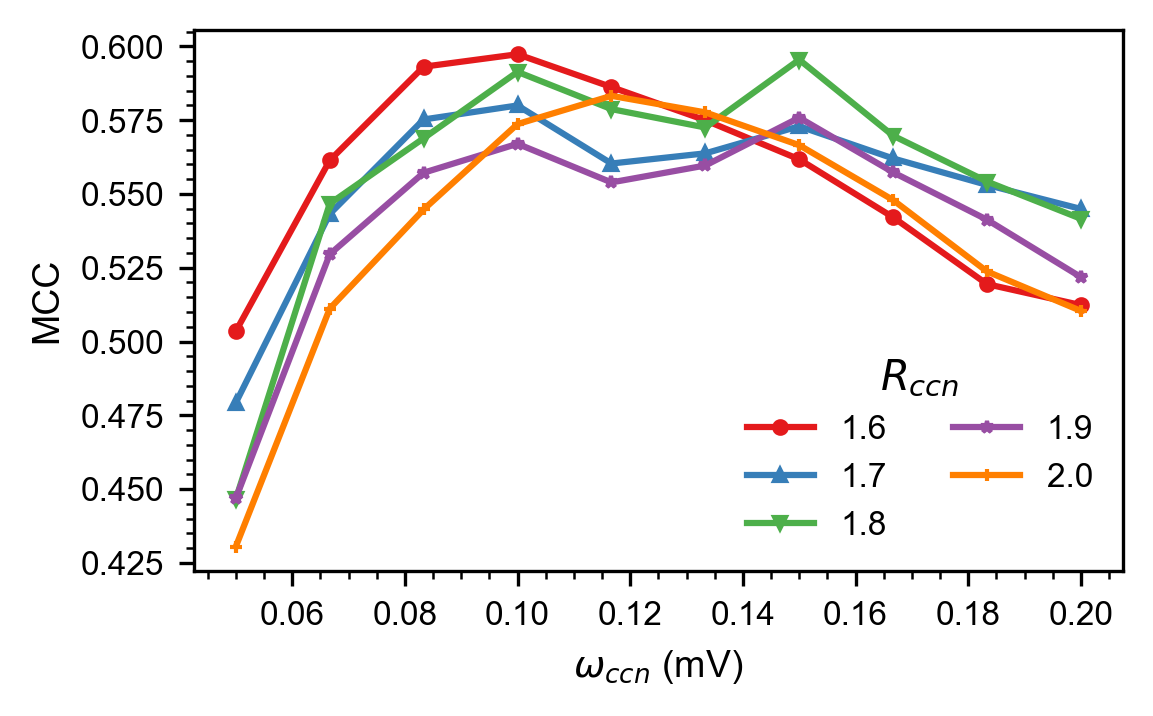

In [10]:
# Create a new figure and axis for plotting
fig, ax = plt.subplots()

# Plot MCC for each ratio and weight combination
for i in range(ratio_array_ccn.size):
    ax.plot(
        w_array_ccn * 1000, 
        MCC_classifier_mean[:, i], 
        color=custom_colors[i], 
        marker=custom_markers[i], 
        label=f"{ratio_array_ccn[i]:.1f}", 
        markersize=3
    )

# Plot parameters  
ax.set_xlabel(r"$\omega_{ccn}$ (mV)")
ax.set_ylabel("MCC")
ax.legend(title=r'$R_{ccn}$', frameon=False, ncol=2)
ax.minorticks_on()

# Adjust layout and save the figure
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/posture_neuron/P2_fig7a.png')

# Print the maximum MCC value rounded to 3 decimal places
print(np.around(np.max(MCC_classifier_mean), 3))


This cell plots the body pitch over time, the spiking activity of the CCN is overlayed.

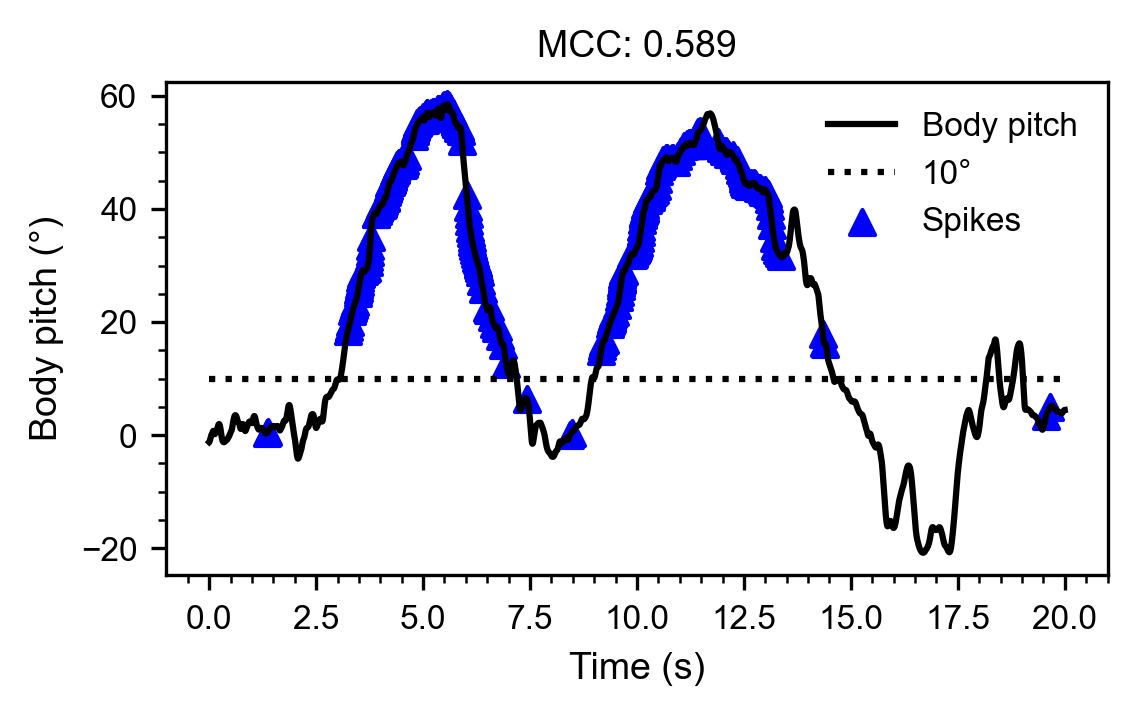

In [11]:
# Find the index of the closest match to the mean MCC value
index_plot = np.argmin(abs(MCC_classifier[index_m, index_l] - np.mean(MCC_classifier[index_m, index_l])))

# Initialize plots
simulations_plot = [index_plot]
spike_climbing_plot = []
pitch_plot = []

# Only show spikes: replace zeros in spike_climbing with NaN
spike_climbing[spike_climbing == 0] = np.nan

# Populate spike_climbing_plot and pitch_plot
for i in simulations_plot:
    spike_climbing_plot.extend(pitch[:, i] * spike_climbing[:, i, index_m, index_l])
    pitch_plot.extend(pitch[:, i])

# Prepare time axis
N_PLOTS = len(simulations_plot)
time = np.linspace(0, N_PLOTS * constants['T_TOTAL_STEP'], num=N_PLOTS * constants['N_STEPS_STEP'])

# Plotting
fig, ax = plt.subplots()

# Plot body pitch
ax.plot(time, pitch_plot, color='black', label='Body pitch')
ax.plot([time[0], time[-1]], [10, 10], linestyle='dotted', color='black', label='10°')

# Scatter plot for climbing spikes
ax.scatter(time, spike_climbing_plot, color='blue', marker='^', label='Spikes')

# Customize plot
ax.minorticks_on()
ax.legend(frameon=False, ncol=1)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Body pitch (°)")
ax.set_title(f"MCC: {MCC_classifier[index_m, index_l, index_plot]:.3f}")

# Layout and save figure
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/posture_neuron/P2_fig7b.png', bbox_inches='tight')

### Pitch Estimator Neuron

The pitch estimator neurons (PENs) encode the stick insect's body pitch through their spike rates. Let's begin by defining the neuron parameters.

In [12]:
# Define pitch estimator neuron parameters
pitch_parameters = {
    'tau': 50e-3,              # Membrane time constant (s)
    'V_T': -50e-3,             # Threshold potential (V)
    'V_R': -70e-3,             # Resting potential (V)
    'n': 2,                    # Number of neurons
    'w': 0,                    # Synaptic weight initialization
    'N_input': 672,            # Number of input neurons
    'dt': constants['dt'],     # Time step size (s)
    'n_sims': 1,               # Number of simulations
    'multiple_synapses': True  # Multiple synapses
}

# Define arrays for synaptic weight and ratio variations
w_array_pen = np.linspace(1e-3, 10e-3, num=11) 
ratio_array_pen = np.linspace(1.5, 1.8, num=6)

# Initialize spike pitch matrix and weights
spike_pitch = np.empty((constants['N_STEPS_STEP'], N_SIMULATIONS_STEP, 2, w_array_pen.size, ratio_array_pen.size))
weights = np.zeros((2, N_PRIM_NEURONS, N_SIMULATIONS_STEP))

# Extract relevant portion of ratio_climb_walk for the simulations
ratio_climb_walk_steps = ratio_climb_walk[:, :N_SIMULATIONS_STEP]

Similar to the CCN, we can connect specific MP INs to the PENs using the ratios. Strongy biased climbing MP INs (high r) are connected with excitatory synapses to PEN+ (index 0) and strongly biased walking MP INs (high 1/r) are connected with excitatory synapses to PEN- (index 1):
$PEN+:\hspace{0.5cm}if\hspace{0.5cm}ratio>r\hspace{0.5cm}then\hspace{0.5cm}\omega = w_\text{PEN}$
$PEN-:\hspace{0.5cm}if\hspace{0.5cm}ratio<1/r\hspace{0.5cm}then\hspace{0.5cm}\omega = w_\text{PEN}$
$else\hspace{0.5cm}\omega = 0$
The weights are rotated such that the trial that is used for the PEN did not contribute to the ratios, and therefore the weights. The LOOCV method ensures the best results.

In [13]:
# Loop through combinations of synaptic weights and ratio arrays
for m, l in tqdm(np.ndindex(w_array_pen.size, ratio_array_pen.size), desc=f'/{w_array_pen.size * ratio_array_pen.size}'):     

    # Update weights based on the current ratio_array value
    within_range = (ratio_climb_walk_steps < ratio_array_pen[l]) & (ratio_climb_walk_steps > 1 / ratio_array_pen[l])
    weights[0, within_range] = 0
    weights[1, within_range] = 0
    
    weights[0, ratio_climb_walk_steps >= ratio_array_pen[l]] = w_array_pen[m]
    weights[1, ratio_climb_walk_steps <= 1 / ratio_array_pen[l]] = w_array_pen[m]
          
    # Iterate over simulations
    for j in range(N_SIMULATIONS_STEP):
        pitch_parameters['w'] = weights[:, :, j]
    
        # Initialize and run the pitch estimator neuron
        pitch_neuron = LIF(pitch_parameters)
        pitch_neuron.initialize_state()
        
        # Forward pass through the neuron for each time step
        for i in range(constants['N_STEPS_STEP']):
            _, spike_pitch[i, j, :, m, l] = pitch_neuron.forward(spike_primitive[i, :, j])

/66: 0it [00:00, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\thoma\AppData\Local\Temp/ipykernel_22096/2398077914.py", line 22, in <module>
    _, spike_pitch[i, j, :, m, l] = pitch_neuron.forward(spike_primitive[i, :, j])
  File "C:\DOCUMENTEN\RUG\Master\Master Research Project\Papers\Jupyter Notebook\classes.py", line 163, in forward
    V += np.sum(w * input, axis=1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeErr

TypeError: object of type 'NoneType' has no len()

In this cell we calculate the accuracy of the PENs. The estimated body pitch (PEN+ - PEN-) is z-normalized and compared to the real body pitch. This result is plotted for each weight and ratio combination. 

In [ ]:
# Initialize MSE array
MSE_array = np.zeros((w_array_pen.size, ratio_array_pen.size, N_SIMULATIONS_STEP))

# Loop through combinations of synaptic weights and ratio arrays
for m, l in tqdm(np.ndindex(w_array_pen.size, ratio_array_pen.size), desc=f'/{w_array_pen.size * ratio_array_pen.size}'):     
    for j in range(N_SIMULATIONS_STEP):
        # Calculate firing rates for PEN+ and PEN- spikes
        spike_rate_plus = get_firing_rate_convolve(spike_pitch[:, j, 0, m, l], constants['dt'], 0.05, nan_bool=False)
        spike_rate_minus = get_firing_rate_convolve(spike_pitch[:, j, 1, m, l], constants['dt'], 0.05, nan_bool=False)
        
        # Normalize the difference between up and down spike rates
        spike_rate_combined_norm = zscore.zscore(spike_rate_plus - spike_rate_minus)
        
        # Normalize the pitch data
        pitch_norm = zscore.zscore(pitch[:, j])
        
        # Compute Mean Squared Error (MSE) between real and estimated body pitch
        MSE_array[m, l, j] = np.mean((spike_rate_combined_norm - pitch_norm) ** 2)
        
# Calculate the mean MSE across simulations
MSE_array_mean = np.mean(MSE_array, axis=2)

# Find the indices (optimal weight and ratio) of the minimum MSE
w_index, ratio_index = np.unravel_index(np.argmin(MSE_array_mean), MSE_array_mean.shape)

# Plotting the results
fig, ax = plt.subplots()

for i in range(ratio_array_pen.size):
    ax.plot(w_array_pen * 1000, MSE_array_mean[:, i], label=f'{ratio_array_pen[i]:.3f}', color=custom_colors[i], marker=custom_markers[i], markersize=3)

# Customize plot
ax.legend(title=r'$R_{pen}$', frameon=False, ncol=2)
ax.set_xlabel(r"$\omega_{pen}$ (mV)")
ax.set_ylabel("MSE")
ax.minorticks_on()

# Layout and save figure
fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/posture_neuron/P2_fig8a.png', bbox_inches='tight')

To visually show the results we plot the z-normalized and real body pitch together. The moving average of the estimated body pitch is also plotted for easy comparison. The highest 10% error, lowest 10% error and average performing simulations are plotted to get an idea of the total performance.  m 

In [ ]:
# Calculate the optimal MSE and corresponding simulations
MSE_opt = MSE_array_mean[w_index, ratio_index]
MSE_opt_sims = MSE_array[w_index, ratio_index]

# Titles for the plots
titles = ['Average', 'Highest 10% error', 'Lowest 10% error']

# Indices for plots: closest to optimal, second highest, second lowest
plot_i = [
    np.argmin(abs(MSE_opt - MSE_opt_sims)),
    second_index(MSE_opt_sims, 'max'),
    second_index(MSE_opt_sims, 'min')
]

# Plot each scenario
for i, name in enumerate(['P2_fig8b', 'P2_fig8c', 'P2_fig8d']):
    spike_rate_up = get_firing_rate_convolve(spike_pitch[:, plot_i[i], 0, w_index, ratio_index], constants['dt'], 0.1, nan_bool=False)
    spike_rate_down = get_firing_rate_convolve(spike_pitch[:, plot_i[i], 1, w_index, ratio_index], constants['dt'], 0.1, nan_bool=False)
    
    spike_rate_up_moving = get_firing_rate_convolve(spike_pitch[:, plot_i[i], 0, w_index, ratio_index], constants['dt'], 1, nan_bool=False)
    spike_rate_down_moving = get_firing_rate_convolve(spike_pitch[:, plot_i[i], 1, w_index, ratio_index], constants['dt'], 1, nan_bool=False)
    
    spike_rate_combined_norm = zscore.zscore(spike_rate_up - spike_rate_down)
    spike_rate_combined_norm_moving = zscore.zscore(spike_rate_up_moving - spike_rate_down_moving)
    
    pitch_norm = zscore.zscore(pitch[:, plot_i[i]])
    
    time = np.linspace(0, 20, num=80000)
    
    fig, ax = plt.subplots()
    
    # Plot the data
    ax.plot(time, spike_rate_combined_norm, color='black', label='Model response', linewidth=0.5)
    ax.plot(time, spike_rate_combined_norm_moving, color=custom_colors[0], label='Moving average')
    ax.plot(time, pitch_norm, color=custom_colors[1], label='Exp. data')
    
    # Set plot limits and labels
    ax.set_ylim(-2.5, 2.5)
    ax.set_title(f'{titles[i]}, MSE: {MSE_opt_sims[plot_i[i]]:.3f}')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Pitch (a.u.)")
    
    ax.minorticks_on()
    
    # Save the figure
    fig.tight_layout(pad=parameters['pad'])
    fig.savefig(f'images/posture_neuron/{name}.png', bbox_inches='tight')


Here we plot the optimal parameters (ratios and weights) into a dataframe

In [ ]:
# Optimal values for climb and pitch based on the indices
w_opt_ccn = w_array_ccn[index_m]
ratio_opt_ccn = ratio_array_ccn[index_l]

w_opt_pen = w_array_pen[w_index]
ratio_opt_pen = ratio_array_pen[ratio_index]

In [ ]:
# Create header and data arrays
header = ['\u03C9 (mV)', 'R', 'MCC/MSE']
data = [
    [f'{w_opt_ccn * 1000:.4f}', f'{w_opt_pen * 1000:.4f}'],
    [f'{ratio_opt_ccn:.3f}', f'{ratio_opt_pen:.3f}'],
    [f'{np.max(MCC_classifier_mean):.3f}', f'{np.max(MSE_opt):.3f}']
]

# Create DataFrame and save to CSV
df = pd.DataFrame(data=data, index=header, columns=['Climb', 'Pitch'])
df.to_csv('results/posture_results_table.csv')

# Display the DataFrame
print(df)